# Introduction

StarCraft is a game that has long been dear to me. I am too young to have gotten into StarCraft 1, but StarCraft 2 was my portal into the PC gaming world. I remember my excitement when I first watched my sister’s husband play the game when I was much younger. I had to stop playing the game since it was too stressful and energy consuming. I only ever reached the rank of Diamond (rank 4 in this dataset), but got close to becoming masters. Since I have knowledge of the skills that are required to become good at StarCraft 2, I thought it would be interesting to analyse StarCraft 1 data.

StarCraft is both a game of tactics and speed. To excel at StarCraft, you must become a master of both. StarCraft is a game of limited information. Each player must gather information about the strategy of your opponent and react accordingly, while trying to catch your opponent off guard with your own strategy. At the same time, you must be fast enough to keep up with what your opponent is doing. Fights can be decided within seconds and your whole economy ruined just as quickly. For this reason, you need to be constantly ready for a attack from your opponent and have to divide your attention to multiple fronts at the same time. 

In this data set we have multiple variables that attempts to measure the speed of each player. APM (Actions Per Minute) and action latency are direct measures of this. The minimap is an essential tool to register attacks coming your way and jumping between different fronts of attack and your economy. Variables such as "Minimap Right Clicks" attempts to measure how good players are at using their minimap. In StarCraft, every owned building or unit may be assigned to a hotkey group. Hotkeys are useful for quickly selecting the units and buildings you need and making actions without having to move your camera, which also saves time. Any good player is expected to use multiple hotkeys. “AssignToHotkeys” measures how many units that are assigned to a given hotkey per timestamp, while “UniqueHotkeys” measures how many unique hotkeys each player uses. 

# Imports


In [19]:
# Data
import pandas as pd
import numpy as np

# Ploting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Matrcis
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


# Preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import sklearn.impute
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder


# Models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import catboost
from Ordinal_Classifier import Ordinal_Classifier as OC #Use: !git clone https://github.com/mosh98/Ordinal_Classifier.git
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.miscmodels.ordinal_model import OrderedModel

# XAI
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.inspection import permutation_importance
from interpret.blackbox import LimeTabular
import shap




# Data


In [2]:
df = pd.read_csv("starcraft_player_data.csv")
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [4]:
df.shape

(3395, 20)

In [3]:
response = 'LeagueIndex'

cat_cols = list(df.select_dtypes(exclude="number").columns)
num_cols = list(df.select_dtypes(include="number").columns)

num_cols.remove(response)

predictors = cat_cols + num_cols
predictors.remove("GameID")

In [6]:
df.isna().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

No missing data since every missing is replaced with "?". We want to change this

In [4]:
df = df.replace("?", np.nan)

In [5]:
df.isna().sum()

GameID                   0
LeagueIndex              0
Age                     55
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

In [6]:
df.dtypes

GameID                    int64
LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

Convert the data type to int.

In [7]:
df["Age"] = df["Age"].astype('Int64')
df["HoursPerWeek"] = df["HoursPerWeek"].astype('Int64')
df["TotalHours"] = df["TotalHours"].astype('Int64')

In [8]:
cat_cols = list(df.select_dtypes(exclude="number").columns)
num_cols = list(df.select_dtypes(include="number").columns)

num_cols.remove(response)
num_cols.remove("GameID")

predictors = cat_cols + num_cols


# Visualization

## Response

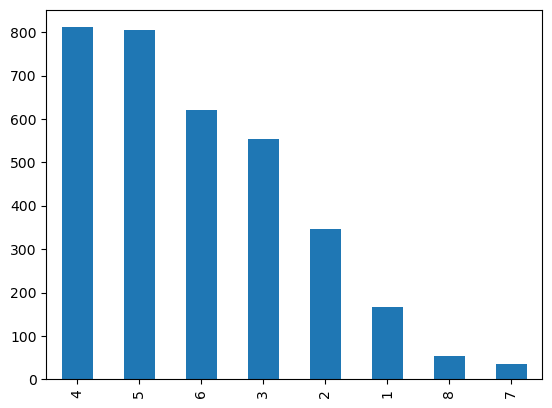

In [13]:
df[response].value_counts().plot(kind = "bar")
plt.show()

Total hours should probably not be a categorical variable

# Predictors

<AxesSubplot: >

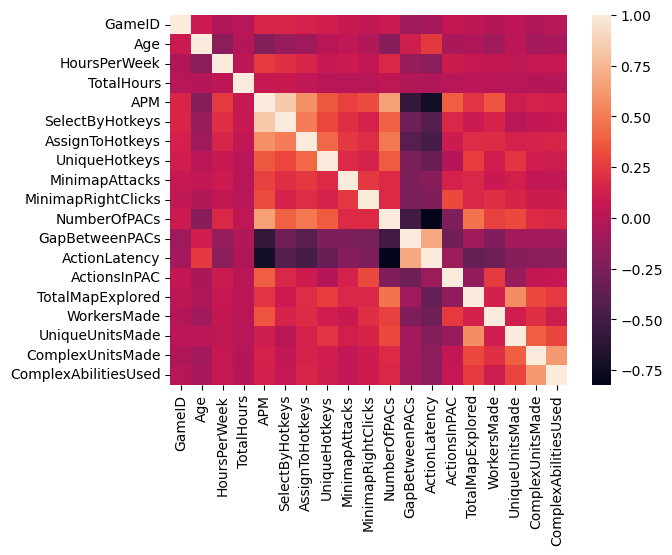

In [18]:
sns.heatmap(df[num_cols].corr())

Most predictors are relative uncorrelated.

In [22]:
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [67]:
continous_var = [var for var in predictors if df.dtypes[var] == "float"]
descreat_var = [var for var in predictors if not var in continous_var]

In [61]:
df[descreat_var].nunique()

Age                  28
HoursPerWeek         32
TotalHours          237
UniqueHotkeys        11
TotalMapExplored     52
UniqueUnitsMade      12
dtype: int64

Total hours has a lot of unique values and is therefor not appropiate to plot.

## Continous variables

In [49]:
lowess = sm.nonparametric.lowess
y = df[response].astype("int64")

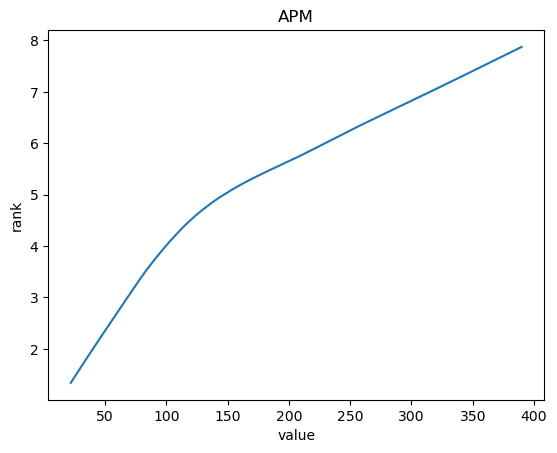

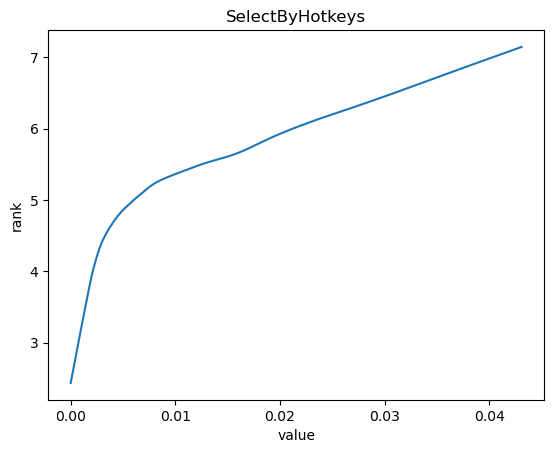

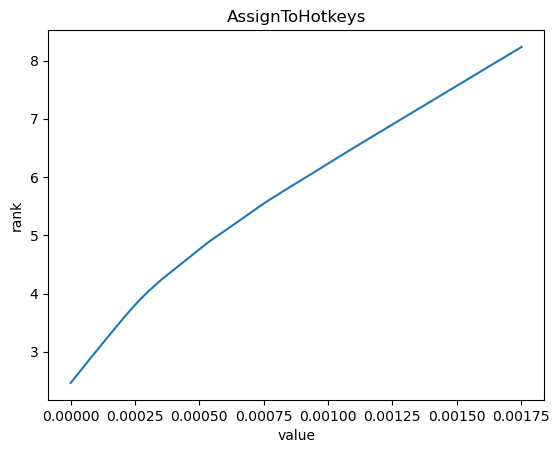

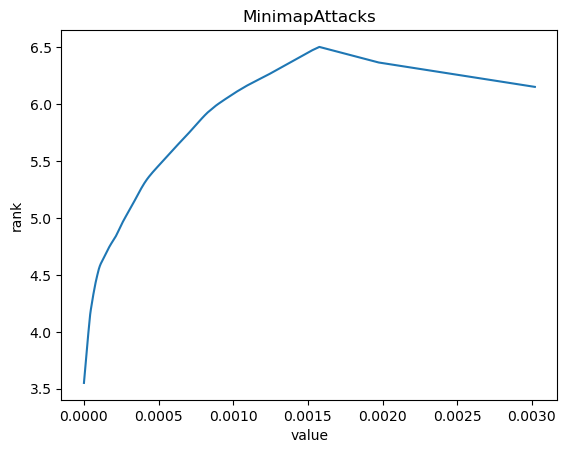

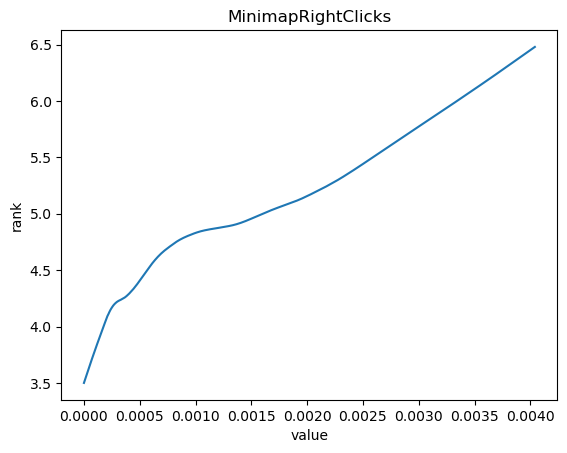

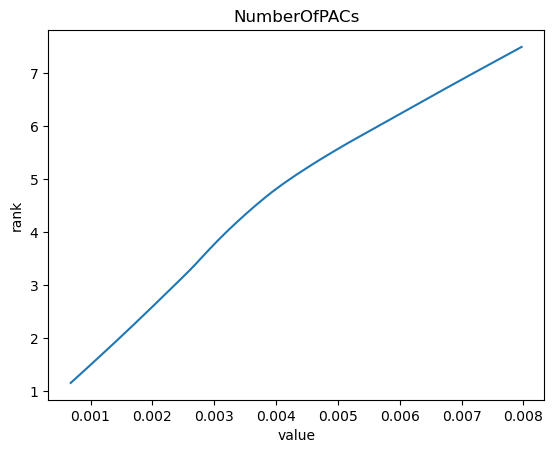

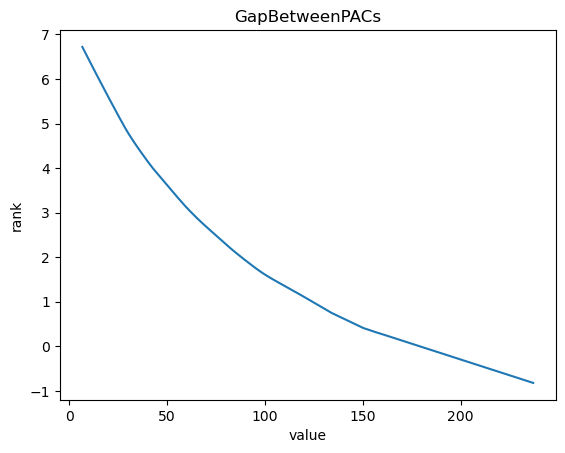

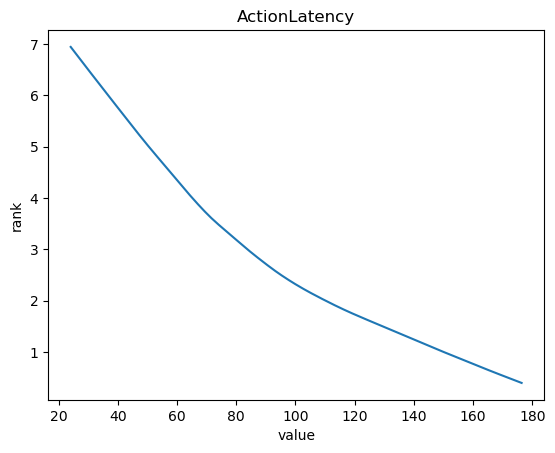

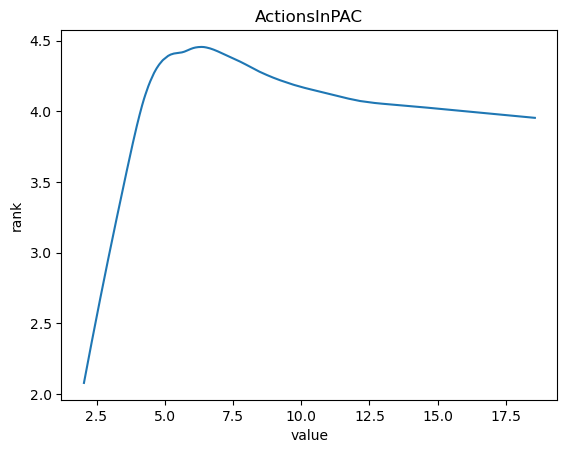

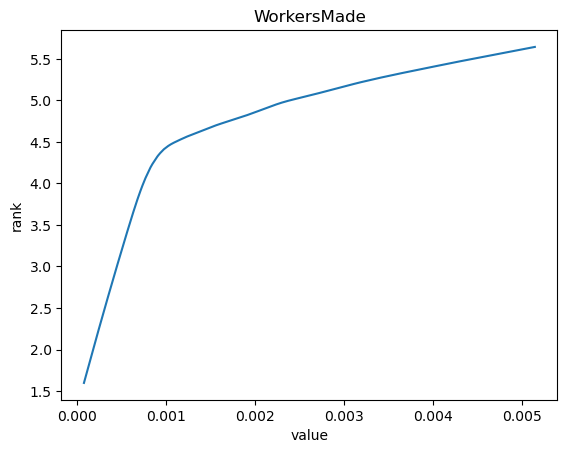

invalid value encountered in divide


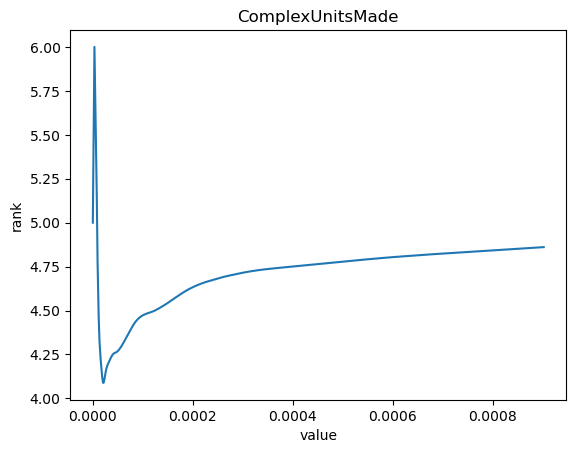

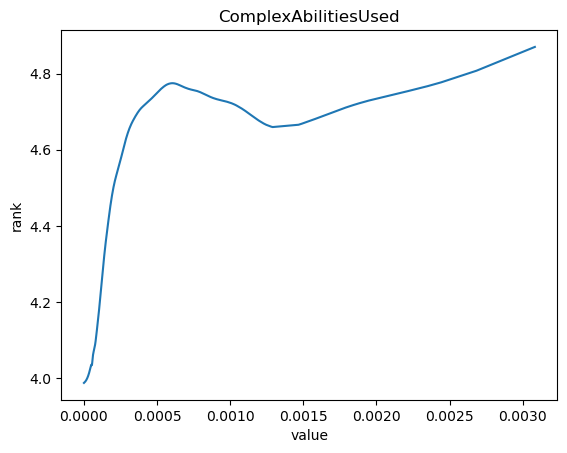

In [68]:
for var in continous_var:
    y_hat = lowess(y, df[var])
    
    plt.plot(y_hat[:,0], y_hat[:,1])
    plt.ylabel("rank")
    plt.xlabel("value")
    plt.title(var)
    plt.show()


Some variables has a clear correlation with rank.

# Preproscessing

In [9]:
X, y = df.loc[:,predictors], df[response]
y = np.array(y) - 1

In [10]:
X.head()

,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [11]:
it_imp = IterativeImputer(random_state=0)

it_imp.fit(X)

imputed = it_imp.transform(X)

X_imp = pd.DataFrame(imputed, columns = X.columns)

In [12]:
X_imp.isna().sum()

Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [13]:
ssc = StandardScaler()
ssc.fit(X_imp[num_cols])
X_imp[num_cols] = ssc.transform(X_imp[num_cols])

X_imp.head()

,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,1.288395,-0.508062,0.115174,0.513521,-0.148288,-0.684207,1.116679,0.069594,0.012948,1.397121,-0.448594,-1.189024,-0.349380,0.789750,0.703205,-0.287506,-0.535072,-0.534971
1,0.332172,-0.508062,0.231607,0.234613,-0.188288,-0.507399,-0.154515,1.180306,0.119380,0.850859,-0.433919,-1.112184,-0.287424,-0.017719,0.311824,-0.825886,-0.535072,0.247698
2,2.005562,-0.508062,-0.047832,-0.906582,-0.605182,-0.168988,-0.154515,1.177699,0.196244,-0.541384,0.249894,0.603835,-0.822947,-0.017719,-0.553320,-0.287506,-0.535072,0.176773
3,-0.624050,0.330517,-0.036189,-0.181859,-0.617967,-0.713535,-1.425710,-0.271524,0.413780,0.322194,-0.649597,-0.520076,-0.239184,-0.421454,-1.166793,0.250874,-0.535072,0.911366
4,2.483673,-0.508062,-0.030367,0.112517,-0.598573,-0.205646,-1.001978,-0.592757,2.496707,-1.103252,-1.030437,-0.086198,2.743858,-0.959766,0.275210,-1.364267,-0.535072,-0.462371


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size = 0.2, random_state = 42)

# Modeling

## XGBoost

In [17]:
xgb_model = xgb.XGBClassifier()

xgb_model.fit(X_train, y_train)

preds = xgb_model.predict(X_test)

In [18]:
conf_mat = confusion_matrix(y_test, preds)
print(conf_mat)

print("Accuracy score:", np.trace(conf_mat)/np.sum(conf_mat))

[[11  8  7  4  1  0  0  0]
 [ 7 23 23 25  2  0  0  0]
 [ 5 13 37 44 11  2  0  0]
 [ 2  5 28 71 51  9  0  1]
 [ 0  3 10 49 59 37  0  0]
 [ 0  0  1 10 42 61  2  1]
 [ 0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0 10]]
Accuracy score: 0.4005891016200295


The model is wrong 60% of the time! Random chance is about 85.7%, so not that great. However, most of the misstakes are made for players in the lower leagues. In particular, the model has a problem with differentiating between ranks 3, 4, 5 (Platinum, Dimond and Masters league), which greatly hurts the accuracy of the model since most of the playerbase is located in this region. 

Interesstingly, the model is great at detecting professional players. The model classified every singel professional player correctly, and only missclassifed two players mistakenly as professional players.

### Metrics that accounts for the inbalance in the data

In [24]:
print("F1 score:", f1_score(y_test, preds, average = "weighted"))
print("Precision score:", precision_score(y_test, preds, average = "weighted"))
print("Recall score:", recall_score(y_test, preds, average = "weighted"))

F1 score: 0.39891397401439477
Precision score: 0.40379539598981795
Recall score: 0.4005891016200295


These metrics performce similar to accuracy, which indicates that the imbalance in the data set does not effect the model much. 

### Parameter tuning

In this part we tune the most important parameters to see if it improves

In [65]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
 param_grid = param_test1, n_jobs=4, cv=5)
gsearch1.fit(X_train, y_train)

In [64]:
best_params = gsearch1.best_params_
best_params

{'max_depth': 9, 'min_child_weight': 3}

In [83]:
param_test2 = {
    "learning_rate":[i/100.0 for i in range(1, 10, 2)],
}

gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier(best_params),
                        param_grid = param_test2, n_jobs=4, cv=5)
gsearch2.fit(X_train, y_train)

Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective={'colsample_bytree': 0.9,
                                                'gamma': 0.0, 'max_depth': 9,
                                                'min_child_weight': 3,
                                                'subsample': 0.8},
                                     predictor=None, random_state=None,
                                     reg_alpha=None, ...),
             n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09]})

In [84]:
best_params.update(gsearch2.best_params_)
print(gsearch2.best_params_, gsearch2.best_score_)

{'learning_rate': 0.05} 0.41826725165204204


In [76]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier(best_params),
                        param_grid = param_test3, n_jobs=4, cv=5)
gsearch3.fit(X_train, y_train)

Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective={'max_depth': 9,
                                                'min_child_weight': 3},
                                     predictor=None, random_state=None,
                                     reg_alpha=None, ...),
             n_jobs=4, param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]})

In [78]:
best_params.update(gsearch3.best_params_)
print(gsearch3.best_params_, gsearch3.best_score_)

({'gamma': 0.0}, 0.4035437655725273)

In [79]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier(best_params),
                        param_grid = param_test4, n_jobs=4, cv=5)
gsearch4.fit(X_train, y_train)

Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective={'gamma': 0.0, 'max_depth': 9,
                                                'min_child_weight': 3},
                                     predictor=None, random_state=None,
                                     reg_alpha=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]})

In [80]:
best_params.update(gsearch4.best_params_)
print(gsearch4.best_params_, gsearch4.best_score_)

{'colsample_bytree': 0.9, 'subsample': 0.8} 0.4153267522478605


### Tuned XGBoost

In [85]:
xgb_model = xgb.XGBClassifier(best_params, n_estimators=5000)

xgb_model.fit(X_train, y_train)

preds = xgb_model.predict(X_test)

Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.


In [86]:
conf_mat = confusion_matrix(y_test, preds)
print(conf_mat)

print("Accuracy score:", np.trace(conf_mat)/np.sum(conf_mat))

[[12  8  4  5  2  0  0  0]
 [10 26 20 22  2  0  0  0]
 [ 8 17 31 37 15  4  0  0]
 [ 4 10 30 70 43  9  0  1]
 [ 0  3  9 44 65 37  0  0]
 [ 0  0  2 10 32 69  3  1]
 [ 0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0 10]]
Accuracy score: 0.4167893961708395


## Catboost

In [49]:
clf = catboost.CatBoostClassifier(iterations=1000, eval_metric = 'Accuracy', verbose = 500)

In [50]:
X_train_cat, X_valid, y_train_cat, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [51]:
clf.fit(X_train_cat, y_train_cat, eval_set = (X_valid, y_valid))

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.109664
0:	learn: 0.3872007	test: 0.3511029	best: 0.3511029 (0)	total: 54.9ms	remaining: 54.9s
500:	learn: 0.9921731	test: 0.3768382	best: 0.4025735 (195)	total: 13.4s	remaining: 13.4s
999:	learn: 1.0000000	test: 0.4025735	best: 0.4044118 (996)	total: 27.3s	remaining: 0us

bestTest = 0.4044117647
bestIteration = 996

Shrink model to first 997 iterations.


In [52]:
preds = clf.predict(X_test)

In [53]:
conf_mat = confusion_matrix(y_test, preds)
print(conf_mat)

print("Accuracy score:", np.trace(conf_mat)/np.sum(conf_mat))

[[14  5  7  5  0  0  0  0]
 [ 7 23 28 22  0  0  0  0]
 [ 5 13 35 45 12  2  0  0]
 [ 3  9 25 65 55 10  0  0]
 [ 0  0  7 47 70 34  0  0]
 [ 0  1  2 11 35 67  1  0]
 [ 0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  1  0  9]]
Accuracy score: 0.4167893961708395


Performs slightly better than the untuned xgboost. Performce equaly well as 

## Explainable Boosting Machine

In [25]:
ebm = ExplainableBoostingClassifier(random_state= 1)
ebm.fit(X_train, y_train)

preds = ebm.predict(X_test)

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions work except for global visualizations, so the line below setting interactions to zero can be disabled if you know what you are doing.


In [26]:
conf_mat = confusion_matrix(y_test, preds)
print(conf_mat)

print("Accuracy score:", np.trace(conf_mat)/np.sum(conf_mat))

[[14  6  6  5  0  0  0  0]
 [ 7 22 28 21  2  0  0  0]
 [ 6 14 26 50 16  0  0  0]
 [ 1  7 22 77 51  9  0  0]
 [ 1  1  6 36 74 40  0  0]
 [ 0  0  0 12 38 67  0  0]
 [ 0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0 10]]
Accuracy score: 0.4270986745213549


In [27]:
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2673610896000/ -->

UniqueUnitsMade, Age and ComplexAbilitesUsed seems to be the least significant variables. Try to remove these to see how it effects performance

In [29]:
predictors_sub = predictors.copy()

In [30]:
predictors_sub.remove("Age")
predictors_sub.remove('UniqueUnitsMade')
predictors_sub.remove('ComplexAbilitiesUsed')

In [31]:
X_train_sub = X_train[predictors_sub] 
X_test_sub = X_test[predictors_sub]

In [34]:
ebm = ExplainableBoostingClassifier(random_state= 1)
ebm.fit(X_train_sub, y_train)

preds = ebm.predict(X_test_sub)

c:\Users\JoNo1\anaconda3\envs\geoenv\lib\site-packages\interpret\glassbox\ebm\ebm.py:568: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions work except for global visualizations, so the line below setting interactions to zero can be disabled if you know what you are doing.



In [35]:
conf_mat = confusion_matrix(y_test, preds)
print(conf_mat)

print("Accuracy score:", np.trace(conf_mat)/np.sum(conf_mat))

[[14  6  4  7  0  0  0  0]
 [ 8 22 27 21  2  0  0  0]
 [ 5 12 29 49 17  0  0  0]
 [ 1  8 21 75 53  9  0  0]
 [ 1  2  5 39 68 43  0  0]
 [ 0  0  0 13 38 66  0  0]
 [ 0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0 10]]
Accuracy score: 0.4182621502209131


Does effect the accuracy

## Ordinal Classifier

Since the response is ordinal (ordered) we may check if ordinal regression makes improvment. Need to use sklearns version of gradient boosting. 

In [32]:
clf = OC.OrdinalClassifier(DecisionTreeClassifier())

clf.fit(X_train, y_train)
  
preds = clf.predict(X_test)

In [33]:
conf_mat = confusion_matrix(y_test, preds)
print(conf_mat)

print("Accuracy score:", np.trace(conf_mat)/np.sum(conf_mat))

[[12 10  5  3  0  1  0  0]
 [13 22 28 13  4  0  0  0]
 [ 7 16 43 32 11  3  0  0]
 [ 4 20 40 52 43  7  1  0]
 [ 1  8 19 43 53 34  0  0]
 [ 2  2  6 27 32 43  5  0]
 [ 0  0  0  1  1  2  0  0]
 [ 0  0  0  0  0  1  0  9]]
Accuracy score: 0.3446244477172312


In [114]:
clf = OC.OrdinalClassifier(GradientBoostingClassifier(n_estimators= 1000))

clf.fit(X_train, y_train)
  
preds = clf.predict(X_test)

In [115]:
conf_mat = confusion_matrix(y_test, preds)
print(conf_mat)

print("Accuracy score:", np.trace(conf_mat)/np.sum(conf_mat))

[[ 9  9  7  5  1  0  0  0]
 [ 7 24 29 20  0  0  0  0]
 [ 3 18 35 39 16  1  0  0]
 [ 0 12 28 74 48  4  0  1]
 [ 0  1 14 36 73 34  0  0]
 [ 0  0  2  9 43 61  1  1]
 [ 0  0  0  0  0  3  1  0]
 [ 0  0  0  0  0  0  0 10]]
Accuracy score: 0.422680412371134


Does indeed make improvements from normal xgboost. However, ebm still performce better, while also beeing explainable. 

## Ordinal Logistic Regression


In [147]:
ord_log_mod = OrderedModel(y_train, X_train, distr = "probit")

ord_log_fit = ord_log_mod.fit(method='bfgs')

pred_mat = ord_log_fit.predict(X_test)

ord_log_fit.summary()

Optimization terminated successfully.
         Current function value: 1.343042
         Iterations: 40
         Function evaluations: 42
         Gradient evaluations: 42


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -3647.7
Model:                   OrderedModel   AIC:                             7345.
Method:            Maximum Likelihood   BIC:                             7493.
Date:                Sun, 05 Feb 2023                                         
Time:                        00:03:07                                         
No. Observations:                2716                                         
Df Residuals:                    2691                                         
Df Model:                          25                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Age                      0.0423      0.022      1.918      0.055      -0.001       0.085
HoursPerWeek             0.1269      0.022      5.865      0.000       0.084       0.169
TotalHours              -0.0266      0.018     -1.467      0.142      -0.062       0.009
APM                     -0.0848      0.133     -0.638      0.523      -0.345       0.176
SelectByHotkeys          0.3300      0.080      4.127      0.000       0.173       0.487
AssignToHotkeys          0.2211      0.028      7.989      0.000       0.167       0.275
UniqueHotkeys            0.0797      0.024      3.386      0.001       0.034       0.126
MinimapAttacks           0.2180      0.022      9.811      0.000       0.174       0.262
MinimapRightClicks       0.0286      0.023      1.228      0.220      -0.017       0.074
NumberOfPACs             0.3336      0.078      4.291      0.000       0.181       0.486
GapBetweenPACs          -0.1829      0.032     -5.722      0.000      -0.246      -0.120
ActionLatency           -0.4295      0.051     -8.448      0.000      -0.529      -0.330
ActionsInPAC             0.0624      0.058      1.074      0.283      -0.051       0.176
TotalMapExplored        -0.0589      0.028     -2.111      0.035      -0.114      -0.004
WorkersMade              0.1200      0.023      5.151      0.000       0.074       0.166
UniqueUnitsMade         -0.0683      0.026     -2.586      0.010      -0.120      -0.017
ComplexUnitsMade         0.0427      0.027      1.552      0.121      -0.011       0.097
ComplexAbilitiesUsed    -0.0051      0.026     -0.195      0.845      -0.056       0.046
0/1                     -2.5873      0.058    -44.582      0.000      -2.701      -2.474
1/2                     -0.0722      0.055     -1.301      0.193      -0.181       0.037
2/3                     -0.1553      0.042     -3.655      0.000      -0.239      -0.072
3/4                     -0.0196      0.035     -0.569      0.569      -0.087       0.048
4/5                      0.0835      0.034      2.437      0.015       0.016       0.151
5/6                      0.6832      0.043     15.740      0.000       0.598       0.768
6/7                     -0.7449      0.167     -4.449      0.000      -1.073      -0.417
========================================================================================
"""

In [148]:
pred_mat = pd.DataFrame(np.array(pred_mat))
preds = np.repeat(0, pred_mat.shape[0])
for index, row in pred_mat.iterrows():
    preds[index] = row.argmax(axis = 0)

In [149]:
conf_mat = confusion_matrix(y_test, preds)
print(conf_mat)

print("Accuracy score:", np.trace(conf_mat)/np.sum(conf_mat))

[[ 7 11  8  5  0  0  0  0]
 [ 9 17 25 28  1  0  0  0]
 [ 2 16 34 43 16  1  0  0]
 [ 0  6 25 79 49  8  0  0]
 [ 0  2  5 52 57 42  0  0]
 [ 0  0  0 15 40 62  0  0]
 [ 0  0  0  0  1  2  0  1]
 [ 0  0  0  0  0  6  0  4]]
Accuracy score: 0.38291605301914583


The performance could probably have been improved with variable selection. However, the model would probably be outperformed by the ebm anyway.